In [98]:
import torch
from torch import nn
from torchvision.models import vgg16_bn,VGG16_BN_Weights
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os 
import glob
from PIL import Image
import numpy as np

In [2]:

class MyDataset(Dataset):
    def __init__(self, data_dir=r"data/VOCdevkit/VOC2012", image_size=(224,224), is_train=True, transform=None):
        super(MyDataset,self).__init__()
        self.transform = transform
        self.is_train = is_train
        self.image_size = image_size
        self.images_list, self.mask_list = self.read_data_list_from(data_dir, self.is_train)
        
        # 定义默认的Albumentations增强
        if self.transform is None:
            if self.is_train:
                self.aug = A.Compose([
                    A.Resize(224, 224),
                    A.HorizontalFlip(p=0.5),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
                    ToTensorV2()
                ], additional_targets={'mask': 'mask'})
            else:
                self.aug = A.Compose([
                    A.Resize(image_size[0], image_size[1]),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
                    ToTensorV2()
                ], additional_targets={'mask': 'mask'})
        else:
            self.aug = self.transform

    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        image_path = self.images_list[index]
        mask_path = self.mask_list[index]
        
        # 读取图像和mask，转换mask中的255为-1
        image = np.array(Image.open(image_path).convert("RGB")).astype(np.float32)
        mask = np.array(Image.open(mask_path)).astype(np.int64)
        mask[mask==255]=-1  # 提前转换255为-1
        
        # 应用数据增强
        augmented = self.aug(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        
        return image, mask
    
    def read_data_list_from(self, root, is_train):
        if is_train ==True:
            data_dir=os.path.join(root,"ImageSets","Segmentation","train.txt")
        else:
            data_dir=os.path.join(root,"ImageSets","Segmentation","val.txt")
        fh=open(data_dir)
        images=[]
        masks=[]
        for line in fh:
            line=line.strip("\n")
            images.append(os.path.join(root,"JPEGImages",line+".jpg"))
            masks.append(os.path.join(root,"SegmentationClass",line+".png"))
                         
        return images, masks

In [3]:
train_ds=DataLoader(MyDataset(),batch_size=32,num_workers=0,shuffle=True)
val_ds=DataLoader(MyDataset(is_train=False),batch_size=32,num_workers=0)

In [4]:
def try_gpu():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

In [5]:
## 网络结构
class FCN8S(torch.nn.Module):
    def __init__(self,out_channels=21):
        super().__init__()
        self.backend=vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1).features
        self.down1=self.backend[0:24]##32,3,28,28
        self.down2=self.backend[24:34]#32,3,14,14
        self.down3=self.backend[34:]#32,3,7,7
        self.conv3=nn.Sequential(
            nn.Conv2d(512,1024,kernel_size=1,padding=0,stride=1,padding_mode='reflect'),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.conv32=nn.Sequential(
            nn.Conv2d(1024,512,kernel_size=1,padding=0,stride=1,padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.up_3=nn.ConvTranspose2d(512,512,kernel_size=4,stride=2,padding=1)
        self.conv2=nn.Sequential(nn.Conv2d(512,512,kernel_size=1,padding=0,stride=1),
                                 nn.BatchNorm2d(512),
                                 nn.ReLU())
        self.up_2=nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1)
        self.conv1=nn.Sequential(nn.Conv2d(256,256,kernel_size=1,padding=0,stride=1),
                                 nn.BatchNorm2d(256),
                                 nn.ReLU())
        self.up_1=nn.ConvTranspose2d(256,out_channels,kernel_size=16,stride=8,padding=4)
    def forward(self,x):
        out_1=self.down1(x)
        out_2=self.down2(out_1)
        out_3=self.down3(out_2)

        out_3=self.conv3(out_3)
        out_3=self.conv32(out_3)
        out_3=self.up_3(out_3)
        out_2=self.conv2(out_2)

        out=out_2+out_3
        out=self.up_2(out)

        out_1=self.conv1(out_1)
        out = out + out_1

        out=self.up_1(out)
        return out

In [6]:
fcn=FCN8S()

In [7]:
## 损失函数
class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2,ignore_dix=255, *args, **kwargs,):
        super().__init__(*args, **kwargs)
        self.alpha=alpha
        self.gamma=gamma
        self.ignore_dix=ignore_dix
    def forward(self,inputs,targets):
        predict=inputs.permute(0,2,3,1).contiguous()
        predict=torch.softmax(predict,dim=-1)
        b,c=predict.size(0),predict.size(3)
        mask=targets!=self.ignore_dix#(batch_size,h,w)
        predict=predict[mask].view(-1,c)
        targets=targets[mask].view(-1)
        one_hot=torch.eye(c,device=predict.device)
        targets=one_hot[targets].view(-1,c).float()#(predict_size,c)
        FL=((-self.alpha*((1-predict)**self.gamma))*targets*torch.log2(predict+1e-12)).sum(dim=-1)#(predict_size,)
        return FL.mean()

In [8]:
## 定义累加器
class Accumulator():
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self, item):
        return self.data[item]

In [40]:
## 定义训练函数
def train(net,train_iter,val_iter,lr,num_epochs,device=None,patience=50):
    # def init_weights(m):
    #     if isinstance(m,nn.Conv2d):
    #         nn.init.kaiming_normal(m.weight)
    # net.apply(init_weights)
    history=[]
    best_val_loss=1.27e-1
    counter=0
    net.to(device)
    print('training on',device)
    loss=FocalLoss(ignore_dix=-1)
    optimizer=torch.optim.Adam(net.parameters(),lr=lr,weight_decay=5e-4)
    batch_size=len(train_iter)
    for epoch in range(num_epochs):
        net.train()
        metric=Accumulator(2)
        print(f"epoch{epoch+1}")
        for i,(X,y) in enumerate(train_iter):
            X,y=X.to(device),y.to(device)
            y=y.squeeze(1).long()
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.sum().backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l,l.numel())
            if (i+1)%(batch_size//5)==0 or i==batch_size-1:
                print(f'\tloss {metric[0]/metric[1]:.5e}')
        ## 验证模式
        net.eval()
        metric2=Accumulator(2)
        with torch.no_grad():
            for X,y in val_iter:
                X,y=X.to(device),y.to(device)
                y=y.squeeze(1).long()
                y_hat=net(X)
                l2=loss(y_hat,y)
                metric2.add(l2,l2.numel())
        print(f'epoch {epoch+1} summary: loss {metric[0]/metric[1]:.5e}, val_loss {metric2[0]/metric2[1]:.5e}')
        if metric2[0]/metric2[1]<best_val_loss:
            best_val_loss=metric2[0]/metric2[1]
            torch.save(net.state_dict(),'model_best.pth')
        else:
            counter+=1
            if counter>=patience:
                print('early stops')
                break
        print(f"best val_loss {best_val_loss:.5e}")
        history.append(metric[0]/metric[1])
    return history

In [74]:
## 开始训练！
history=train(fcn,train_ds,val_ds,lr=1e-7,num_epochs=20,device=try_gpu())

training on cuda
epoch1
	loss 7.87851e-03
	loss 7.67320e-03
	loss 7.73817e-03
	loss 7.57114e-03
	loss 7.41072e-03
	loss 7.38489e-03
epoch 1 summary: loss 7.38489e-03, val_loss 1.30327e-01
best val_loss 1.27000e-01
epoch2
	loss 6.63423e-03
	loss 7.46258e-03
	loss 7.35281e-03
	loss 7.20608e-03
	loss 7.04430e-03
	loss 7.03923e-03
epoch 2 summary: loss 7.03923e-03, val_loss 1.30892e-01
best val_loss 1.27000e-01
epoch3
	loss 6.72577e-03
	loss 6.98383e-03
	loss 7.18095e-03
	loss 7.20847e-03
	loss 7.07644e-03
	loss 7.07281e-03
epoch 3 summary: loss 7.07281e-03, val_loss 1.33292e-01
best val_loss 1.27000e-01
epoch4
	loss 6.93317e-03
	loss 7.23615e-03
	loss 7.31056e-03
	loss 7.31894e-03
	loss 7.19476e-03
	loss 7.16667e-03
epoch 4 summary: loss 7.16667e-03, val_loss 1.31159e-01
best val_loss 1.27000e-01
epoch5
	loss 6.91601e-03
	loss 6.66328e-03
	loss 6.78996e-03
	loss 6.81121e-03
	loss 6.97376e-03
	loss 6.93756e-03
epoch 5 summary: loss 6.93756e-03, val_loss 1.30424e-01
best val_loss 1.27000e-0

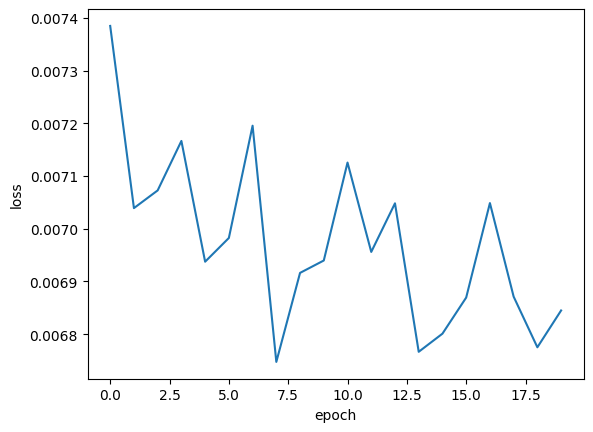

In [75]:
plt.plot(history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 在验证集上测试模型

In [8]:
## 定义预测函数
def predict(net,data_iter,num=15,idx=2):
    fcn.load_state_dict(torch.load("model_best.pth",weights_only=False))
    iters=iter(data_iter)
    for j in range(idx-1):
        next(iters)
    image,target=next(iters)
    images,targets=[],[]
    net.to(try_gpu())
    net.eval()
    with torch.no_grad():
        pred=net(image.to(try_gpu()))
    for i in range(num):
        images.append(image[i].permute(1,2,0).detach().cpu())
        targets.append(target[i].detach().cpu())
    return images,targets,pred

In [87]:
origin,targets,preds=predict(fcn,val_ds,idx=2)

In [88]:
predicted=preds.argmax(1)
predicted.shape

torch.Size([32, 224, 224])

In [89]:
preds=[predicted[i].detach().cpu() for i in range(15)]
len(preds)

15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

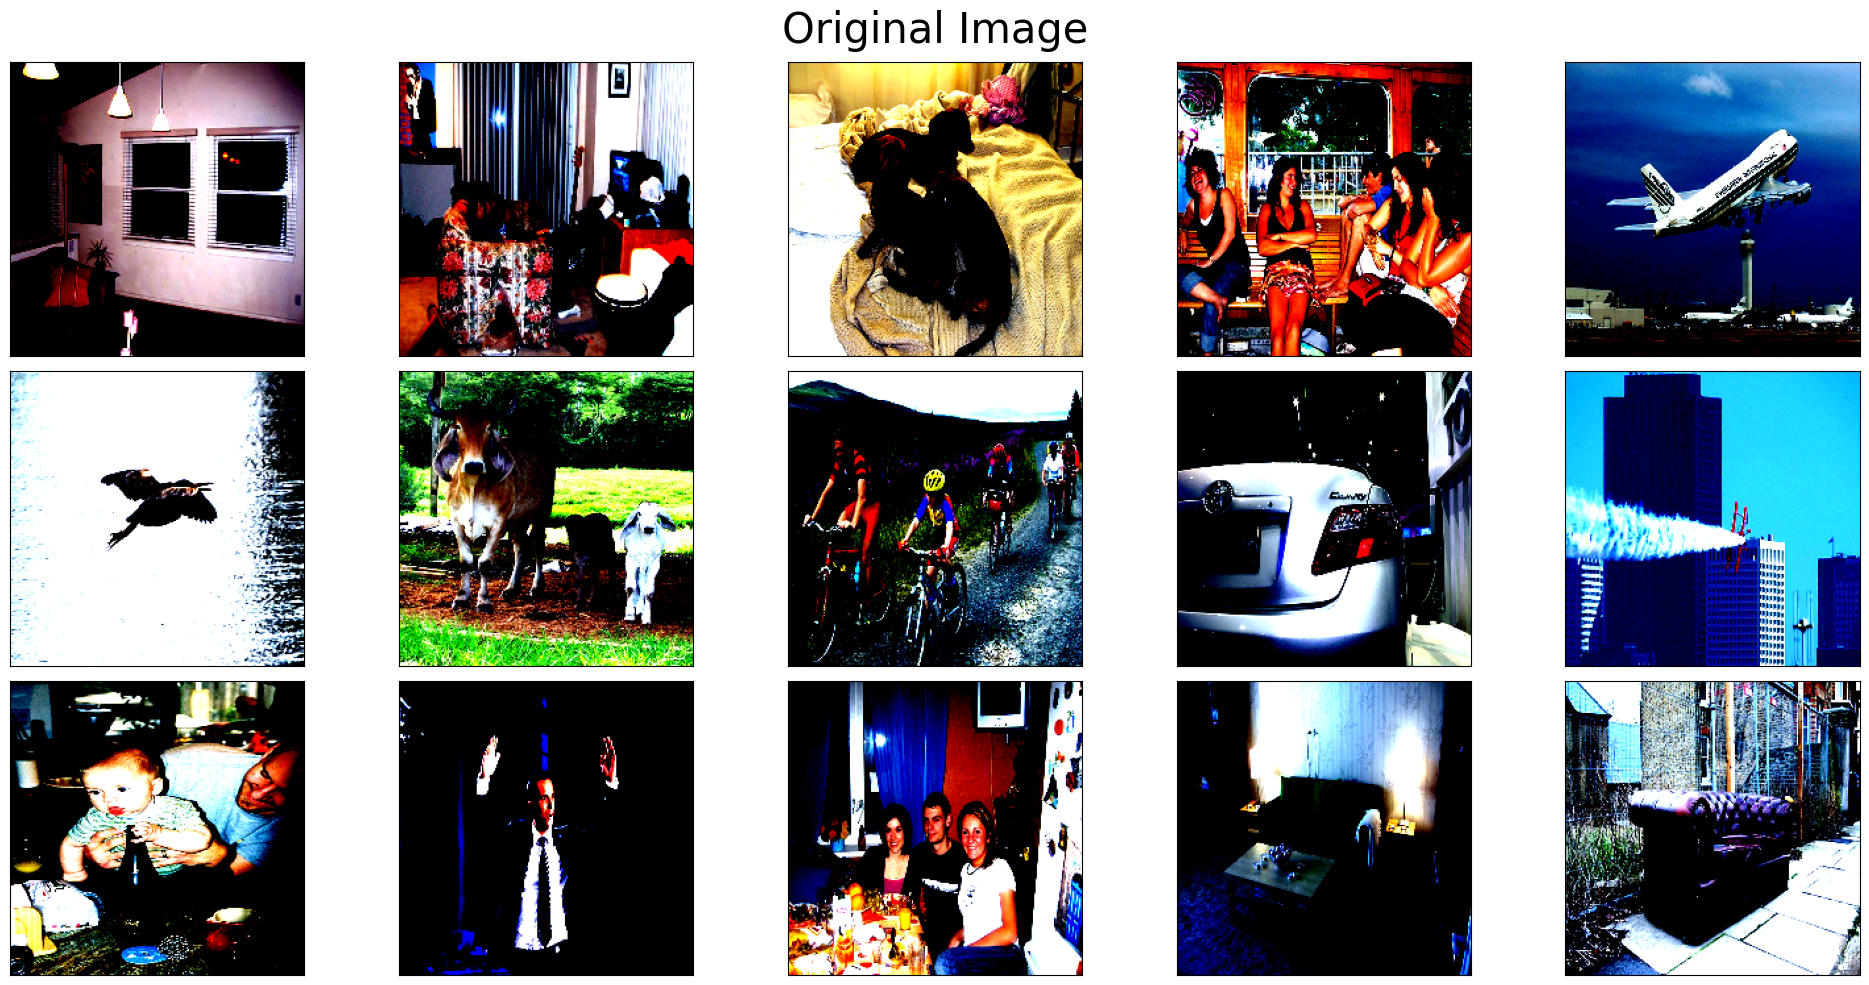

In [90]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(origin[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Original Image',fontsize=30)
fig.tight_layout()
plt.show()

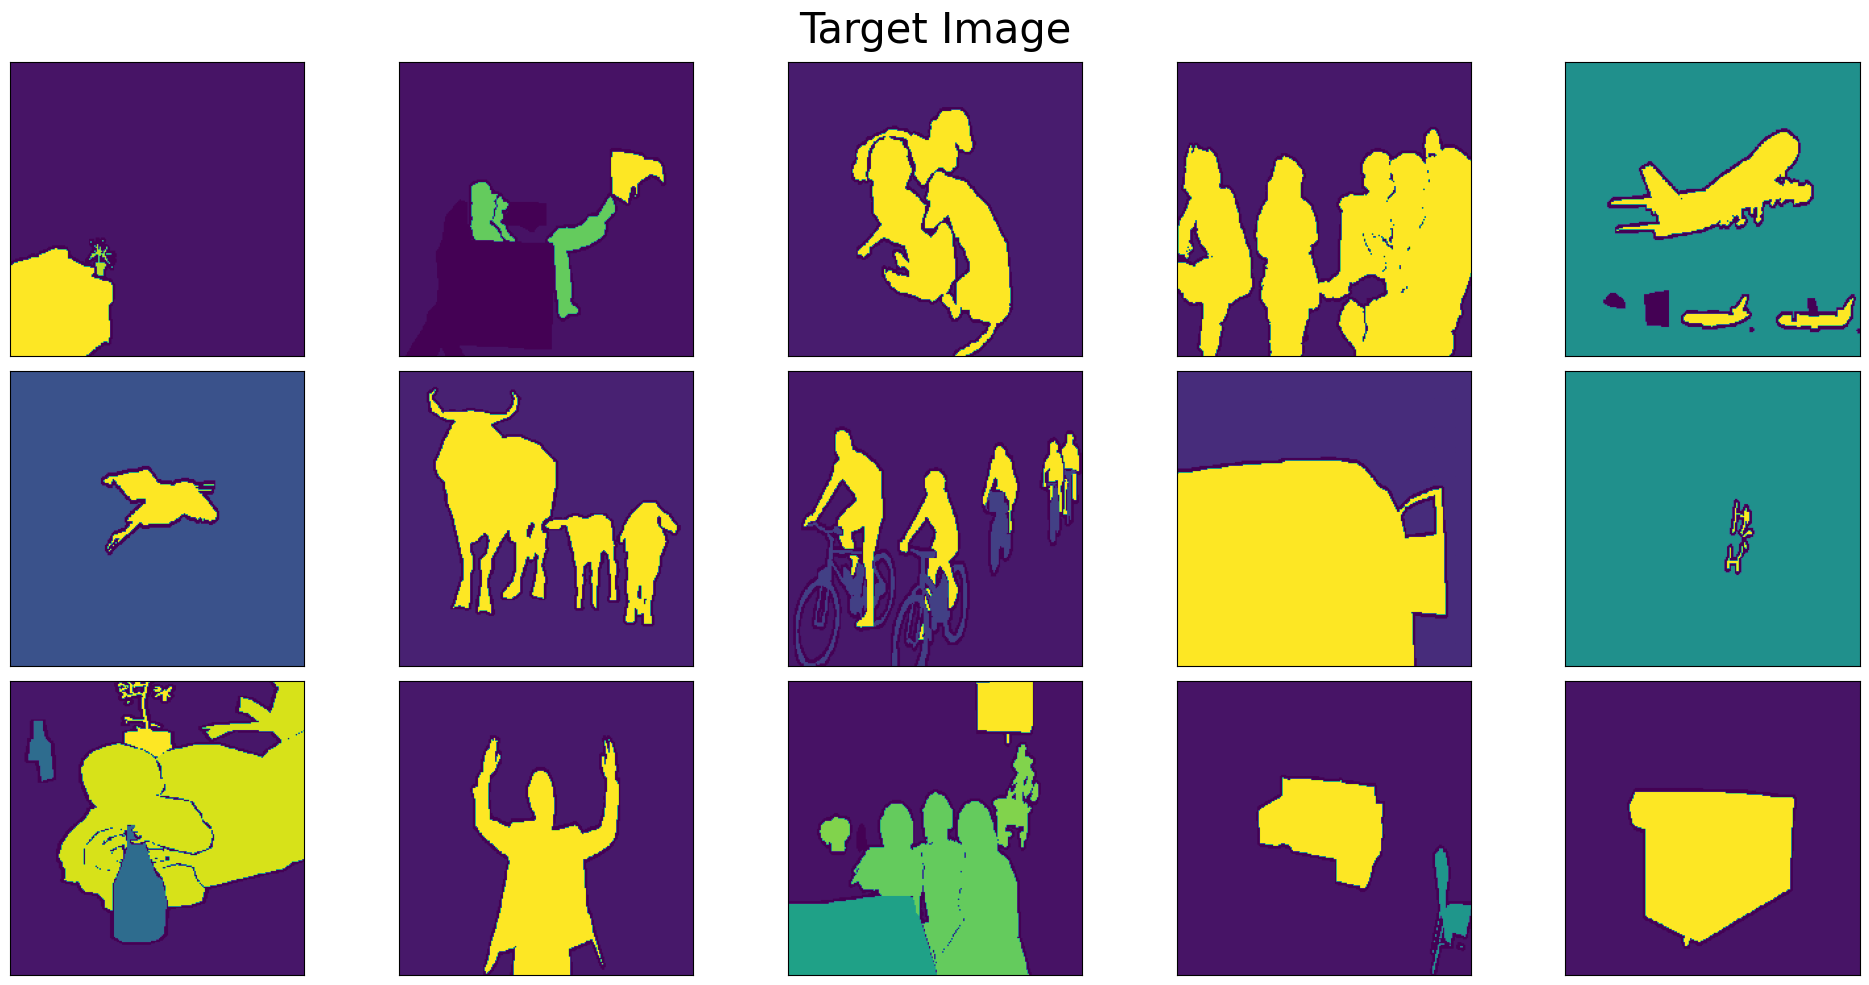

In [91]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(targets[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Target Image',fontsize=30)
fig.tight_layout()
plt.show()

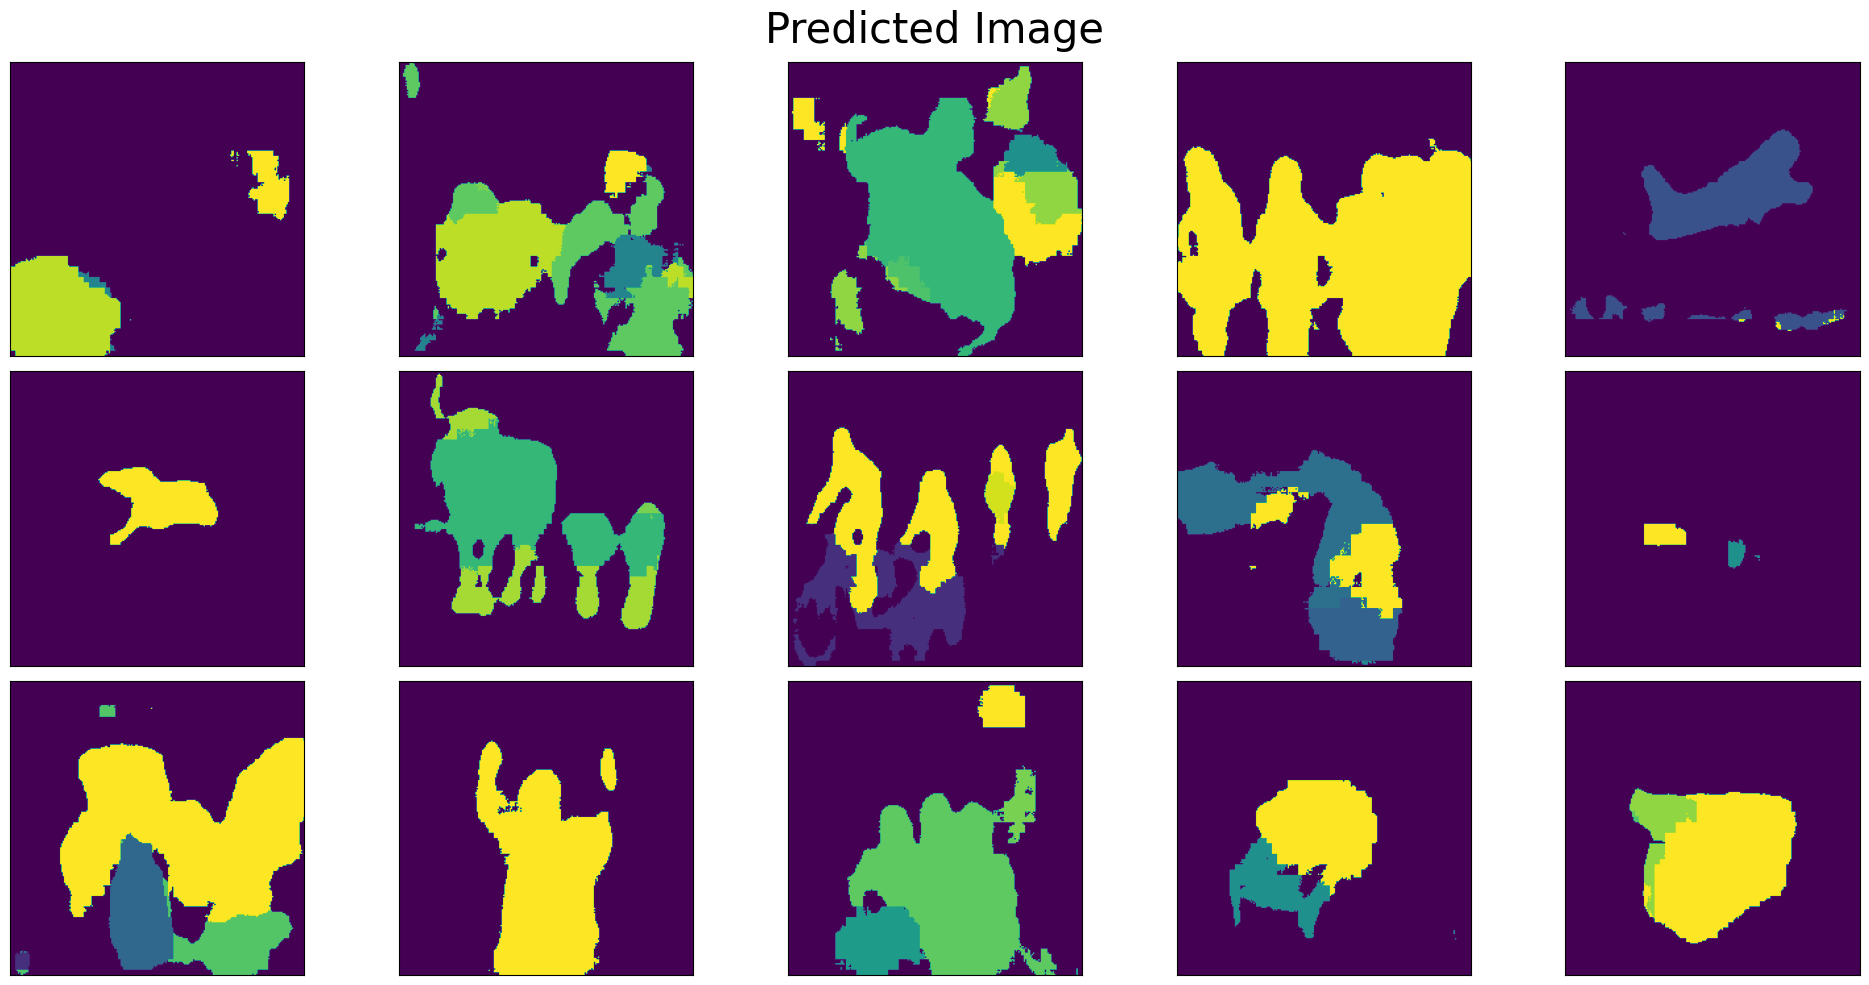

In [92]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(preds[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Predicted Image',fontsize=30)
fig.tight_layout()
plt.show()

In [65]:
## 定义预测函数
def predict_one(net,data_dir):
    fcn.load_state_dict(torch.load("model_best.pth",weights_only=False))
    test_image=np.array(Image.open(data_dir).convert("RGB"))
    fig,ax=plt.subplots(1,2)
    ax[0].imshow(test_image)
    ax[0].set_xticks(())
    ax[0].set_yticks(())
    aug = A.Compose([
                A.Resize(224, 224),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()])
    tensor_image=aug(image=test_image.astype(np.float32))["image"]
    net.to(try_gpu())
    net.eval()
    with torch.no_grad():
        pred=net(tensor_image.unsqueeze(0).to(try_gpu()))
    pred_image=pred.argmax(1)
    ax[1].imshow(pred_image.permute(1,2,0).detach().cpu())
    ax[1].set_xticks(())
    ax[1].set_yticks(())
    plt.show()

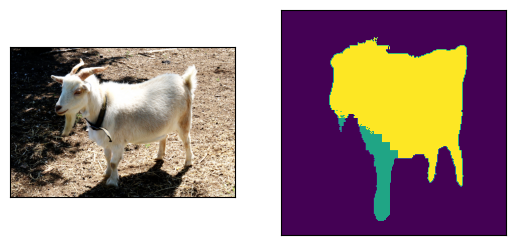

In [68]:
predict_one(fcn,r"sheep.jpeg")

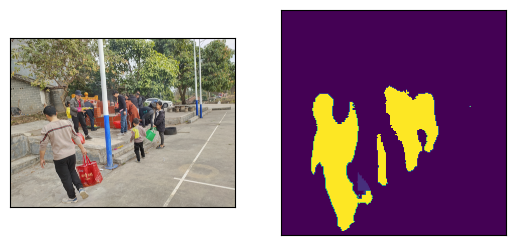

In [69]:
predict_one(fcn,r"persons.jpg")

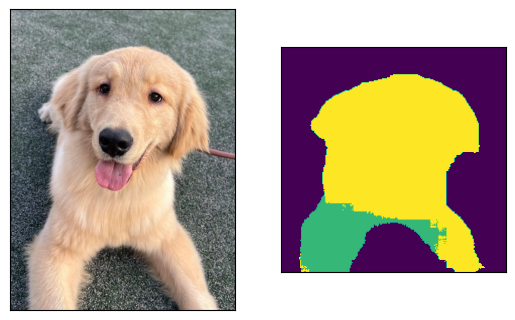

In [70]:
predict_one(fcn,r"dog.jpeg")

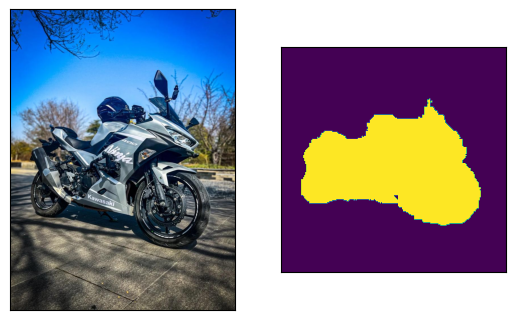

In [71]:
predict_one(fcn,"motor.jpeg")

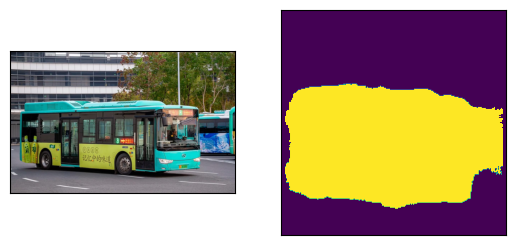

In [73]:
predict_one(fcn,r"bus.jpeg")

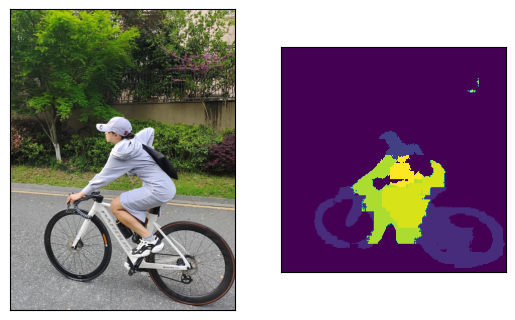

In [74]:
predict_one(fcn,r"bike.jpeg")

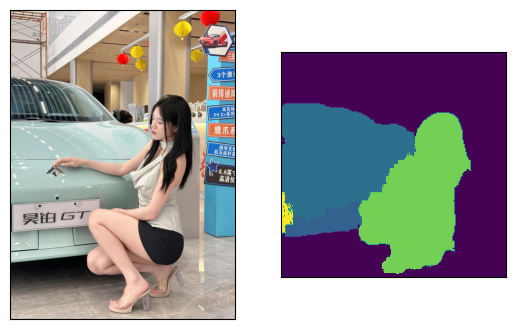

In [76]:
predict_one(fcn,r"car.jpeg")

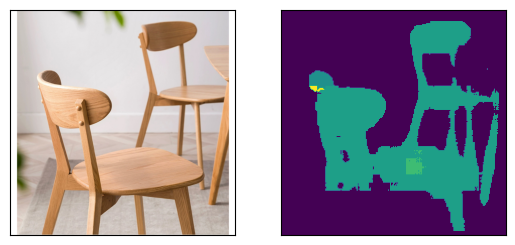

In [78]:
predict_one(fcn,r"chair.jpeg")

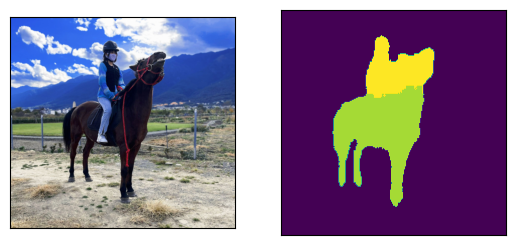

In [79]:
predict_one(fcn,r"horse.jpeg")

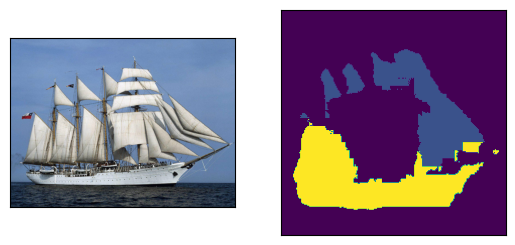

In [80]:
predict_one(fcn,r"ship.jpeg")

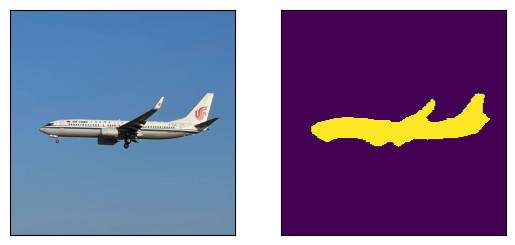

In [93]:
predict_one(fcn,r"plane.jpeg")

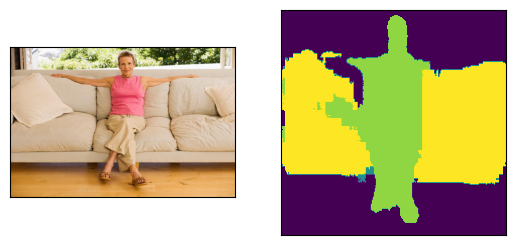

In [96]:
predict_one(fcn,r"sofa.jpeg")

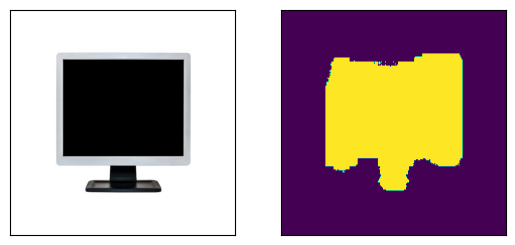

In [97]:
predict_one(fcn,r"tv.jpeg")

## 恭喜！你完成了自己的第一个FCN-8S网络